In [1]:
import pandas as pd
from pathlib import Path
from src import stats, plotting
import warnings
from scipy.stats import spearmanr
from tqdm import tqdm

pd.set_option('display.max_rows', None)

In [2]:
process = 'EEG_RSA'
eeg_metric = 'decoding'
fmri_metric = 'decoding'
regress_gaze = False

run_splithalf_reliability = True
run_fmri_rsa = False
run_feature_decoding = True
run_feature_rsa = True

top_path = '/Users/emcmaho7/Dropbox/projects/SI_EEG/SIEEG_analysis'
data_dir = f'{top_path}/data'
Path(f'{data_dir}/interim/{process}').mkdir(exist_ok=True, parents=True)

In [3]:
rois = ['EVC', 'MT', 'EBA',
        'LOC', 'FFA', 'PPA',
        'pSTS', 'face-pSTS', 'aSTS']
features = ['alexnet', 'moten', 'indoor',
                 'expanse', 'object_directedness', 'agent_distance',
                 'facingness', 'joint_action', 'communication', 
                 'valence', 'arousal']
annotated_features = ['indoor', 'expanse', 'object_directedness', 
                 'agent_distance', 'facingness', 'joint_action', 
                 'communication', 'valence', 'arousal']

In [ ]:
channels = None
other_cols = set(['trial', 'time', 'offset', 'offset_eyetrack_x', 'video_name',
              'gaze_x', 'gaze_y', 'pupil_size', 'target_x', 'target_y',
               'target_distance', 'offset_eyetrack_y', 'repetition', 'even', 'session'])
feature_df = pd.read_csv(f'{data_dir}/interim/FeatureRDMs/feature_annotations.csv')

df = []
max_time = 2
for session, subj in enumerate(['subj001', 'subj010']):
    cur = pd.read_csv(f'{data_dir}/interim/PreprocessData/{subj}_reg-gaze-{regress_gaze}.csv.gz')
    cur['session'] = session
    if cur.time.max() < max_time:
        max_time = cur.time.max()
    df.append(cur)
df = pd.concat(df).reset_index(drop=True)
df = df.loc[df.time <= max_time]
channels = list(set(df.columns.to_list()) - other_cols)

df.drop(columns=['offset_eyetrack_x', 'gaze_x', 'gaze_y',
       'pupil_size', 'target_x', 'target_y', 'target_distance',
       'offset_eyetrack_y'], inplace=True)

df.to_csv(f'{data_dir}/interim/PreprocessData/pseudo010_reg-gaze-False.csv.gz', index=False, compression='gzip')

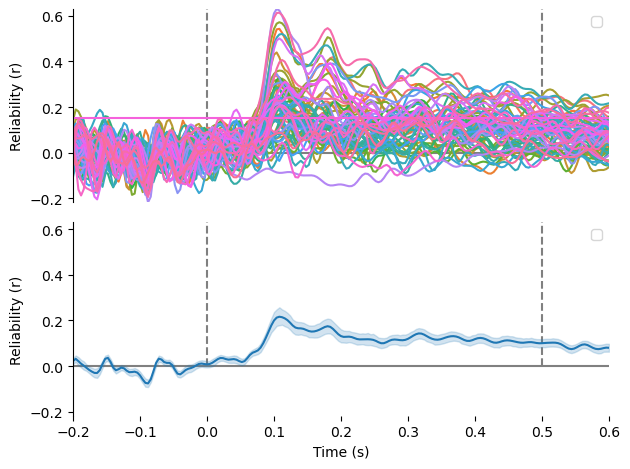

In [10]:
df_split = df.groupby(['time', 'video_name', 'even']).mean().reset_index()
results = []
time_groups = df_split.groupby('time')
for time, time_df in time_groups:
    even = time_df[time_df.even].sort_values('video_name')
    odd = time_df[~time_df.even].sort_values('video_name')
    rs = stats.corr2d(even[channels].to_numpy(), odd[channels].to_numpy())
    results.append([time,] + list(rs))
results = pd.DataFrame(results, columns=['time',] + channels)
results = pd.melt(results, id_vars=['time'], value_vars=channels, var_name='channel', value_name='reliability')

plotting.plot_splithalf_reliability(results, None)

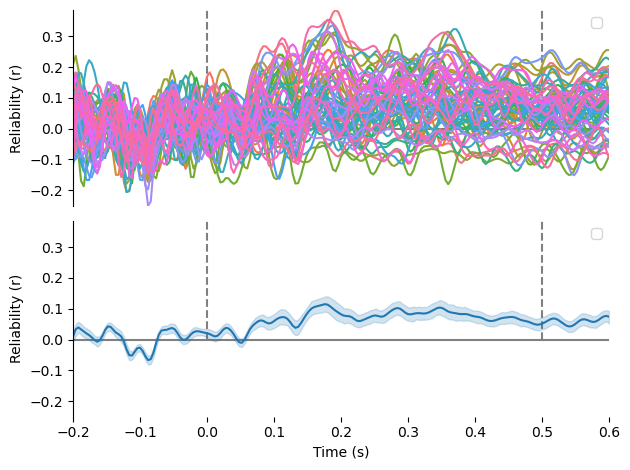

In [5]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="Mean of empty slice")
    
    df_split = df.groupby(['time', 'video_name', 'session']).mean().reset_index()
    results = []
    time_groups = df_split.groupby('time')
    for time, time_df in time_groups:
        even = time_df[time_df.session == 0].sort_values('video_name')
        odd = time_df[time_df.session == 1].sort_values('video_name')
        rs = stats.corr2d(even[channels].to_numpy(), odd[channels].to_numpy())
        results.append([time,] + list(rs))
    results = pd.DataFrame(results, columns=['time',] + channels)
    results = pd.melt(results, id_vars=['time'], value_vars=channels, var_name='channel', value_name='reliability')

    plotting.plot_splithalf_reliability(results, None)